In [1]:
import cv2
import os
from detectron2.structures import BoxMode
def get_annotation(datapath, annotation):
    # dict field refer to https://detectron2.readthedocs.io/tutorials/datasets.html
    # annotation is information for bounding box
    # objectness is information for classes, for example
    # 0 is knee center without medal implants
    # 1 is knee center with medal implants
    class_name = 'Knee'
    all_imgs = {}
    with open(annotation,'r') as f:
        print('Parsing annotation files')
        for line in f:
            line_split = line.strip().split(',')
            # limited to single knee, only one box per image
            (img_id, x1, y1, x2, y2) = line_split
            # (img_id, x1, y1, x2, y2, objectness) = line_split
            if img_id not in all_imgs:
                all_imgs[img_id] = {}
                all_imgs[img_id]['image_id'] = img_id
                img_filepath = os.path.join(datapath, img_id)
                assert os.path.exists(img_filepath), img_filepath
                all_imgs[img_id]['file_name'] = img_filepath            
                img = cv2.imread(img_filepath)
                (rows,cols) = img.shape[:2]                
                all_imgs[img_id]['width'] = cols
                all_imgs[img_id]['height'] = rows
                all_imgs[img_id]['annotations'] = []
                
            all_imgs[img_id]['annotations'].append(
                {'bbox': [int(x1), int(y1), int(x2), int(y2)],
                 'bbox_mode': BoxMode.XYXY_ABS,
                 "category_id": int(0),
                 # "category_id": int(objectness),
                }
            )
    all_data = []
    for key in all_imgs:
        all_data.append(all_imgs[key])
    return all_data

In [2]:
import os
src_lat_path = os.path.join('..','KneeQualityAssurance', 'data', 'Data','lat','png_all')
annotations_lat_train_fn = "train_labeled_lat_metal.txt"
annotations_lat_test_fn = "test_labeled_lat_metal.txt"
annotations_lat_fn = 'LAT_annotate.txt'


In [3]:
annotations_lat_train = get_annotation(src_lat_path, annotations_lat_fn)

Parsing annotation files


In [4]:
from detectron2.data import DatasetCatalog
DatasetCatalog.clear()

In [5]:
# from detectron2.data import DatasetCatalog
# DatasetCatalog.clear()
# for d in ["train", "test"]:
#     DatasetCatalog.register("knee_lat_" + d, lambda d=d:get_annotation(src_lat_path, d + '_labeled_lat_metal.txt'))
    

In [6]:
from detectron2.data import DatasetCatalog
DatasetCatalog.clear()
for d in ["train"]:
    DatasetCatalog.register("knee_lat_" + d, lambda d=d:get_annotation(src_lat_path, 'LAT_annotate.txt'))
    

In [7]:
from detectron2.data import DatasetCatalog
DatasetCatalog.list()

['knee_lat_train']

In [8]:
from detectron2.data import MetadataCatalog
MetadataCatalog.get("knee").thing_classes = ["knee"]
# MetadataCatalog.get("knee").thing_colors = [(255,48,48), (0,255,0)]

In [9]:
MetadataCatalog.get("knee").thing_classes

['knee']

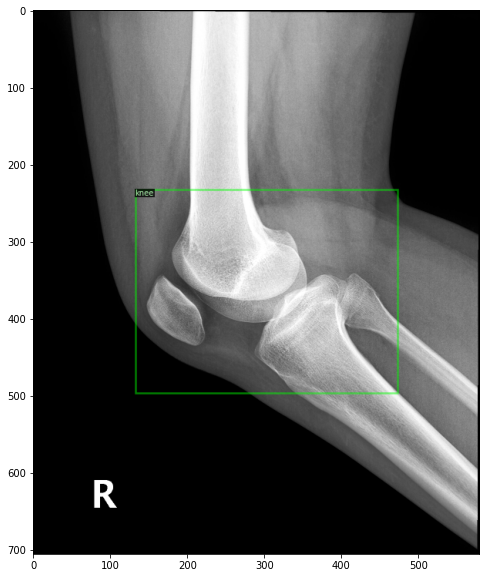

In [11]:
# Visualize the dataset visualizer only work for 8 bit images
import random
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
%matplotlib inline
from detectron2.utils.visualizer import Visualizer
knee_metadata = MetadataCatalog.get("knee")
plt.rcParams['figure.figsize'] = (8, 15)

for d in random.sample(annotations_lat_train, 1):
    # img = np.array(Image.open(d["file_name"]))
    img = cv2.cvtColor(cv2.imread(d["file_name"],flags = cv2.IMREAD_ANYCOLOR | cv2.IMREAD_ANYDEPTH),cv2.COLOR_BGR2RGB)
    if len(img.shape) < 3:
        img = np.repeat(img[:, :, np.newaxis], 3, axis=2)
    visualizer = Visualizer(img, metadata=knee_metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    plt.imshow(vis.get_image())

In [14]:
from detectron2.engine import DefaultTrainer
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.data import MetadataCatalog, DatasetCatalog
import os
import time
cfg = get_cfg()
cfg.merge_from_file('./configs/COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml')
# cfg.MODEL.WEIGHTS = './snapshots/model_final_b275ba.pkl'
cfg.DATASETS.TRAIN = ("knee_ap_train",)
cfg.DATASETS.TRAIN = ("knee_lat_train",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.004
cfg.SOLVER.STEPS = (12000, 16000)
cfg.SOLVER.MAX_ITER = (20000) 
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 256
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1
cfg.MODEL.RPN.PRE_NMS_TOPK_TRAIN = 256
cur_snapshot = time.strftime('%Y_%m_%d_%H_%M_%S')
cur_anatomy = 'LAT'
cfg.OUTPUT_DIR = cur_anatomy  + '_' + time.strftime('%Y_%m_%d_%H_%M_%S')

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

[06/11 17:31:42 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

In [3]:
from detectron2.data import DatasetCatalog
src_lat_path = os.path.join('..','KneeQualityAssurance', 'data', 'Data','lat','png_all')
DatasetCatalog.clear()
for d in ["train", "test"]:
    for fold in range(1,4):
        DatasetCatalog.register("knee_lat_" + d + '_fold{}'.format(fold), lambda d=d:get_annotation(src_lat_path, d + '_labeled_lat_metal_fold{}.txt'.format(fold)))
    

In [13]:
os.makedirs

<function os.makedirs(name, mode=511, exist_ok=False)>

In [5]:
import os
src_lat_path = os.path.join('..','KneeQualityAssurance', 'data', 'Data','lat','png_all')
annotations_lat_test = get_annotation(src_ap_path, 'test_labeled_lat_metal_fold1.txt')

Parsing annotation files


In [5]:
from detectron2.engine import DefaultTrainer
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.data import MetadataCatalog, DatasetCatalog
import os
import time
cfg = get_cfg()
cfg.merge_from_file('./configs/COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml')
# cfg.MODEL.WEIGHTS = './snapshots/model_final_b275ba.pkl'

cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.004
cfg.SOLVER.STEPS = (12000, 16000)
cfg.SOLVER.MAX_ITER = (20000) 
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 256
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 2
cfg.MODEL.RPN.PRE_NMS_TOPK_TRAIN = 256
for fold in range(1,4):
    cur_snapshot = time.strftime('%Y_%m_%d_%H_%M_%S')
    cur_anatomy = 'LAT'
    cfg.OUTPUT_DIR = cur_anatomy  + '_' + time.strftime('%Y_%m_%d_%H_%M_%S') + '_fold{}'.format(fold)
    cfg.DATASETS.TRAIN = ('knee_lat_train_fold{}'.format(fold),)
    os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
    trainer = DefaultTrainer(cfg)
    trainer.resume_or_load(resume=False)
    trainer.train()

[04/24 17:56:36 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

In [9]:
'knee_ap_train_fold{}'.format(fold)

'knee_ap_train_fold1'

In [11]:
# Look at training curves in tensorboard:
!kill 4992
%load_ext tensorboard
%tensorboard --logdir output

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


invalid info file: '/tmp/.tensorboard-info/pid-6032.info'
Traceback (most recent call last):
  File "/home/ken/anaconda3/envs/py36/lib/python3.6/site-packages/tensorboard/manager.py", line 316, in get_all
    info = _info_from_string(contents)
  File "/home/ken/anaconda3/envs/py36/lib/python3.6/site-packages/tensorboard/manager.py", line 155, in _info_from_string
    raise ValueError("incompatible version: %r" % (json_value,))
ValueError: incompatible version: {'cache_key': 'eyJhcmd1bWVudHMiOlsiLS1sb2dkaXIiLCJsb2dzX3Rlc3QiXSwiY29uZmlndXJlX2t3YXJncyI6e30sIndvcmtpbmdfZGlyZWN0b3J5IjoiL2hvbWUva2VuL0RvY3VtZW50cy9LbmVlUXVhbGl0eUFzc3VyYW5jZS91dGlsIn0=', 'db': '', 'logdir': 'logs_test', 'path_prefix': '', 'pid': 6032, 'port': 6006, 'start_time': 1579419047, 'version': '2.0.0'}
invalid info file: '/tmp/.tensorboard-info/pid-6032.info'
Traceback (most recent call last):
  File "/home/ken/anaconda3/envs/py36/lib/python3.6/site-packages/tensorboard/manager.py", line 316, in get_all
    info = _inf

In [12]:
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.data import MetadataCatalog, DatasetCatalog
import os
import time
cfg = get_cfg()
cfg.merge_from_file('./configs/COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml')
# cfg.OUTPUT_DIR = 'AP_2020_04_10_12_00_00'
cfg.OUTPUT_DIR = 'LAT_2020_04_14_10_15_54'
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 2
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.8   # set the testing threshold for this model
cfg.DATASETS.TEST = ("knee_ap_test")
# cfg.DATASETS.TEST = ("knee_lat_test")
predictor = DefaultPredictor(cfg)

In [24]:
cfg.INPUT.FORMAT

'BGR'

(1416, 1320, 3)
Inference time is 0.436s
{'instances': Instances(num_instances=1, image_height=1416, image_width=1320, fields=[pred_boxes: Boxes(tensor([[ 255.0821,  507.3262,  979.7842, 1118.7152]], device='cuda:0')), scores: tensor([0.9998], device='cuda:0'), pred_classes: tensor([0], device='cuda:0')])}


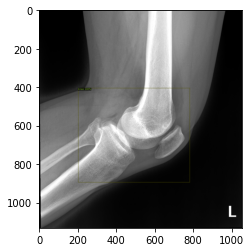

In [14]:
import random
import time
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
from detectron2.utils.visualizer import Visualizer
from detectron2.utils.visualizer import ColorMode
knee_ap_metadata = MetadataCatalog.get("knee")
# for d in random.sample(annotations_ap_test, 1):
for d in random.sample(annotations_lat_train, 1):    
#     im = cv2.imread(d["file_name"], flags = cv2.IMREAD_ANYCOLOR | cv2.IMREAD_ANYDEPTH)
#     if len(im.shape) < 3:
#         im = np.repeat(im[:, :, np.newaxis], 3, axis=2)
    im = cv2.imread(d["file_name"]) # No tag will read the gray image as colored image BGR
    print(im.shape)
    start = time.time()
    outputs = predictor(im)
    print('Inference time is {:.3}s'.format(np.round(time.time() - start, 4)))
    v = Visualizer(im[:, :, ::-1],
                   metadata=knee_ap_metadata, 
                   scale=0.8
    )
    print(outputs)
    # img_gt = v.draw_dataset_dict(d)   
    img_pred_gt = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    plt.imshow(cv2.cvtColor(img_pred_gt.get_image()[:, :, ::-1], cv2.COLOR_BGR2RGB))

In [72]:
bbox = outputs["instances"].pred_boxes.to("cpu")
[x1, y1, x2, y2] = bbox.tensor.squeeze().numpy()
print(x1)

140.37271


In [103]:
bbox = outputs["instances"].pred_boxes.to("cpu")
preds =outputs["instances"].pred_classes.to("cpu")
pred_index = np.argmax(preds)
print(bbox.tensor[1])

tensor([ 309.8042,  765.2216, 1270.2040, 1853.7509])


In [109]:
# output test result to txt file
from collections import Counter
result_txt = 'test_predicted_ap_metal.txt'
with open(result_txt, 'w') as f:
    # for d in random.sample(annotations_test, 1):
    for d in annotations_test:
        im = cv2.imread(d["file_name"])
        outputs = predictor(im)
        bbox = outputs["instances"].pred_boxes.to("cpu").tensor.squeeze().numpy()
        preds =outputs["instances"].pred_classes.to("cpu").numpy()
        if len(preds) > 1: # predicted two boxes
            preds_counter= Counter(preds)
            if preds_counter[0] == 1 and preds_counter[1] == 1:
                pred_index = np.argmax(preds)
                preds = preds[pred_index]
                bbox = bbox[pred_index]
            else:
                print('Error:' + d["file_name"])
                continue
        [x1, y1, x2, y2] = bbox
        rowtxt = '{},{},{},{},{},{}'.format(d["image_id"], int(x1), int(y1), int(x2), int(y2), int(preds))
        f.write(rowtxt)
        f.write('\n')

In [20]:
# output test result to txt file
from collections import Counter
result_txt = 'test_predicted_lat_metal.txt'
with open(result_txt, 'w') as f:
    # for d in random.sample(annotations_test, 1):
    for d in annotations_lat_test:
        im = cv2.imread(d["file_name"])
        outputs = predictor(im)
        bbox = outputs["instances"].pred_boxes.to("cpu").tensor.squeeze().numpy()
        preds =outputs["instances"].pred_classes.to("cpu").numpy()
        if len(preds) > 1: # predicted two boxes
            print(outputs)
            preds_counter= Counter(preds)
            if preds_counter[0] == 1 and preds_counter[1] == 1:
                pred_index = np.argmax(preds)
                preds = preds[pred_index]
                bbox = bbox[pred_index]
            else:
                print('Error:' + d["file_name"])
                continue
        elif len(preds) == 0:
            print('No boxes detected on ' + d["file_name"])
            bbox = np.array([-1,-1,-1,-1])
            preds = -1
        [x1, y1, x2, y2] = bbox
        rowtxt = '{},{},{},{},{},{}'.format(d["image_id"], int(x1), int(y1), int(x2), int(y2), int(preds))
        f.write(rowtxt)
        f.write('\n')

{'instances': Instances(num_instances=2, image_height=2836, image_width=1700, fields=[pred_boxes: Boxes(tensor([[ 497.0834,  940.9330, 1293.2606, 1741.0341],
        [ 470.4921,  906.7751, 1288.7825, 1734.7714]], device='cuda:0')), scores: tensor([0.9465, 0.8147], device='cuda:0'), pred_classes: tensor([1, 0], device='cuda:0')])}
{'instances': Instances(num_instances=2, image_height=2019, image_width=1320, fields=[pred_boxes: Boxes(tensor([[ 304.0228,  732.1901, 1171.7609, 1613.0105],
        [ 322.0814,  762.8668, 1083.9058, 1655.0376]], device='cuda:0')), scores: tensor([0.9628, 0.8854], device='cuda:0'), pred_classes: tensor([1, 0], device='cuda:0')])}


In [15]:
bbox = np.array([-1,-1,-1,-1])
[x1, y1, x2, y2] = bbox

In [24]:
import itertools
def iou(boxA, boxB):
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])

    interArea = max(0, xB - xA) * max(0, yB - yA)

    boxAArea = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    boxBArea = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])

    iou = interArea / float(boxAArea + boxBArea - interArea)
    return iou 

def cal_iou_from_file(gt_file, pred_file):
    content = []
    boxA = []
    boxB = []
    predA = []
    predB = []
    result = {}
    filea = open(gt_file,"r")
    fileb = open(pred_file,"r")
    for linea in filea:
        line_split = linea.strip().split(',')
        (filename, x1, y1, x2, y2, objectness) = line_split
        if filename not in content:
            content.append(filename)
            boxA.append([int(x1), int(y1), int(x2), int(y2)])
            predA.append(int(objectness))
            
    for lineb in fileb:
        line_split = lineb.strip().split(',')
        (filename, x1, y1, x2, y2, objectness) = line_split
        if filename in content:
            boxB.append([int(x1), int(y1), int(x2), int(y2)])
            predB.append(int(objectness))
    
    sum = 0.0
    count = 0
    for index in range(len(boxA)):
        s = iou(boxA[index], boxB[index])
        if s > 0.7 and predA[index] == predB[index]:
            count += 1
        else: 
            print(content[index])
            print(s)
            print(predA[index])
            print(predB[index])
        # result[content[index]] = (s, boxA[index], boxB[index])
        result[content[index]] = [s] + list(itertools.chain(boxA[index], boxB[index])) + [predA[index]] + [predB[index]]
        sum = sum + s  
    mean = sum/len(boxA)
    accuracy = count/len(boxA)
    print(mean)
    print(accuracy)
    return result

In [25]:
gt_file = "test_labeled_ap_metal.txt"
pred_file = "test_predicted_ap_metal.txt"
result_AP = cal_iou_from_file(gt_file, pred_file)

0.9297886260371733
1.0


In [26]:
gt_file = "test_labeled_lat_metal.txt"
pred_file = "test_predicted_lat_metal.txt"
result_AP = cal_iou_from_file(gt_file, pred_file)

D3497307_L.png
0.8772129201148828
1
0
D3667677_L.png
0.9391727398224659
1
0
D3091984_L.png
0.8874528520158622
1
0
D3505154_L.png
0.8982399163820296
1
0
0.9323925263054136
0.9871794871794872


In [21]:
import pandas as pd
df_result_AP = df_result_AP = pd.DataFrame.from_dict(result_AP, orient='index', columns = ['IOU',
                                                                                           'x1_A', 'y1_A', 'x2_A', 'y2_A',
                                                                                           'x1_B', 'y1_B','x2_B','y2_B',
                                                                                           'pred_A', 'pred_B'])
df_result_AP = df_result_AP.sort_values(by='IOU')
df_AP_qauntile = df_result_AP['IOU'].quantile(np.arange(0,1,0.1))
print(df_AP_qauntile)
print(len(df_result_AP))
df_AP_bot10 = df_result_AP[df_result_AP['IOU'] < df_result_AP['IOU'].quantile(0.1)]
print(len(df_AP_bot10))
df_AP_bot10.head()


0.0    0.770743
0.1    0.887562
0.2    0.907740
0.3    0.922509
0.4    0.933246
0.5    0.940591
0.6    0.948660
0.7    0.953153
0.8    0.959311
0.9    0.967509
Name: IOU, dtype: float64
312
32


IOU  x1_A  y1_A  x2_A  y2_A  x1_B  y1_B  x2_B  y2_B  \
D3220395_L.png  0.770743   241   377   988  1001   260   437   905   994   
W0549025_R.png  0.779869   110   765   845  1692   157   791   805  1611   
D3492920_L.png  0.787793   403   536  1112  1045   388   491  1111  1123   
W0544633_R.png  0.794885   281   738  1023  1774   304   837  1048  1711   
D2648524_R.png  0.825254   141   483   941  1089   133   457   855  1111   

                pred_A  pred_B  
D3220395_L.png       0       0  
W0549025_R.png       1       1  
D3492920_L.png       0       0  
W0544633_R.png       1       1  
D2648524_R.png       0       0

In [124]:
gt_bbox = np.array(df_AP_bot10.loc[image_fn][['x1_A', 'y1_A', 'x2_A', 'y2_A']].values)
pred_bbox = np.array(df_AP_bot10.loc[image_fn][['x1_B', 'y1_B', 'x2_B', 'y2_B']].values)
np.vstack((gt_bbox, pred_bbox)).shape

(2, 4)

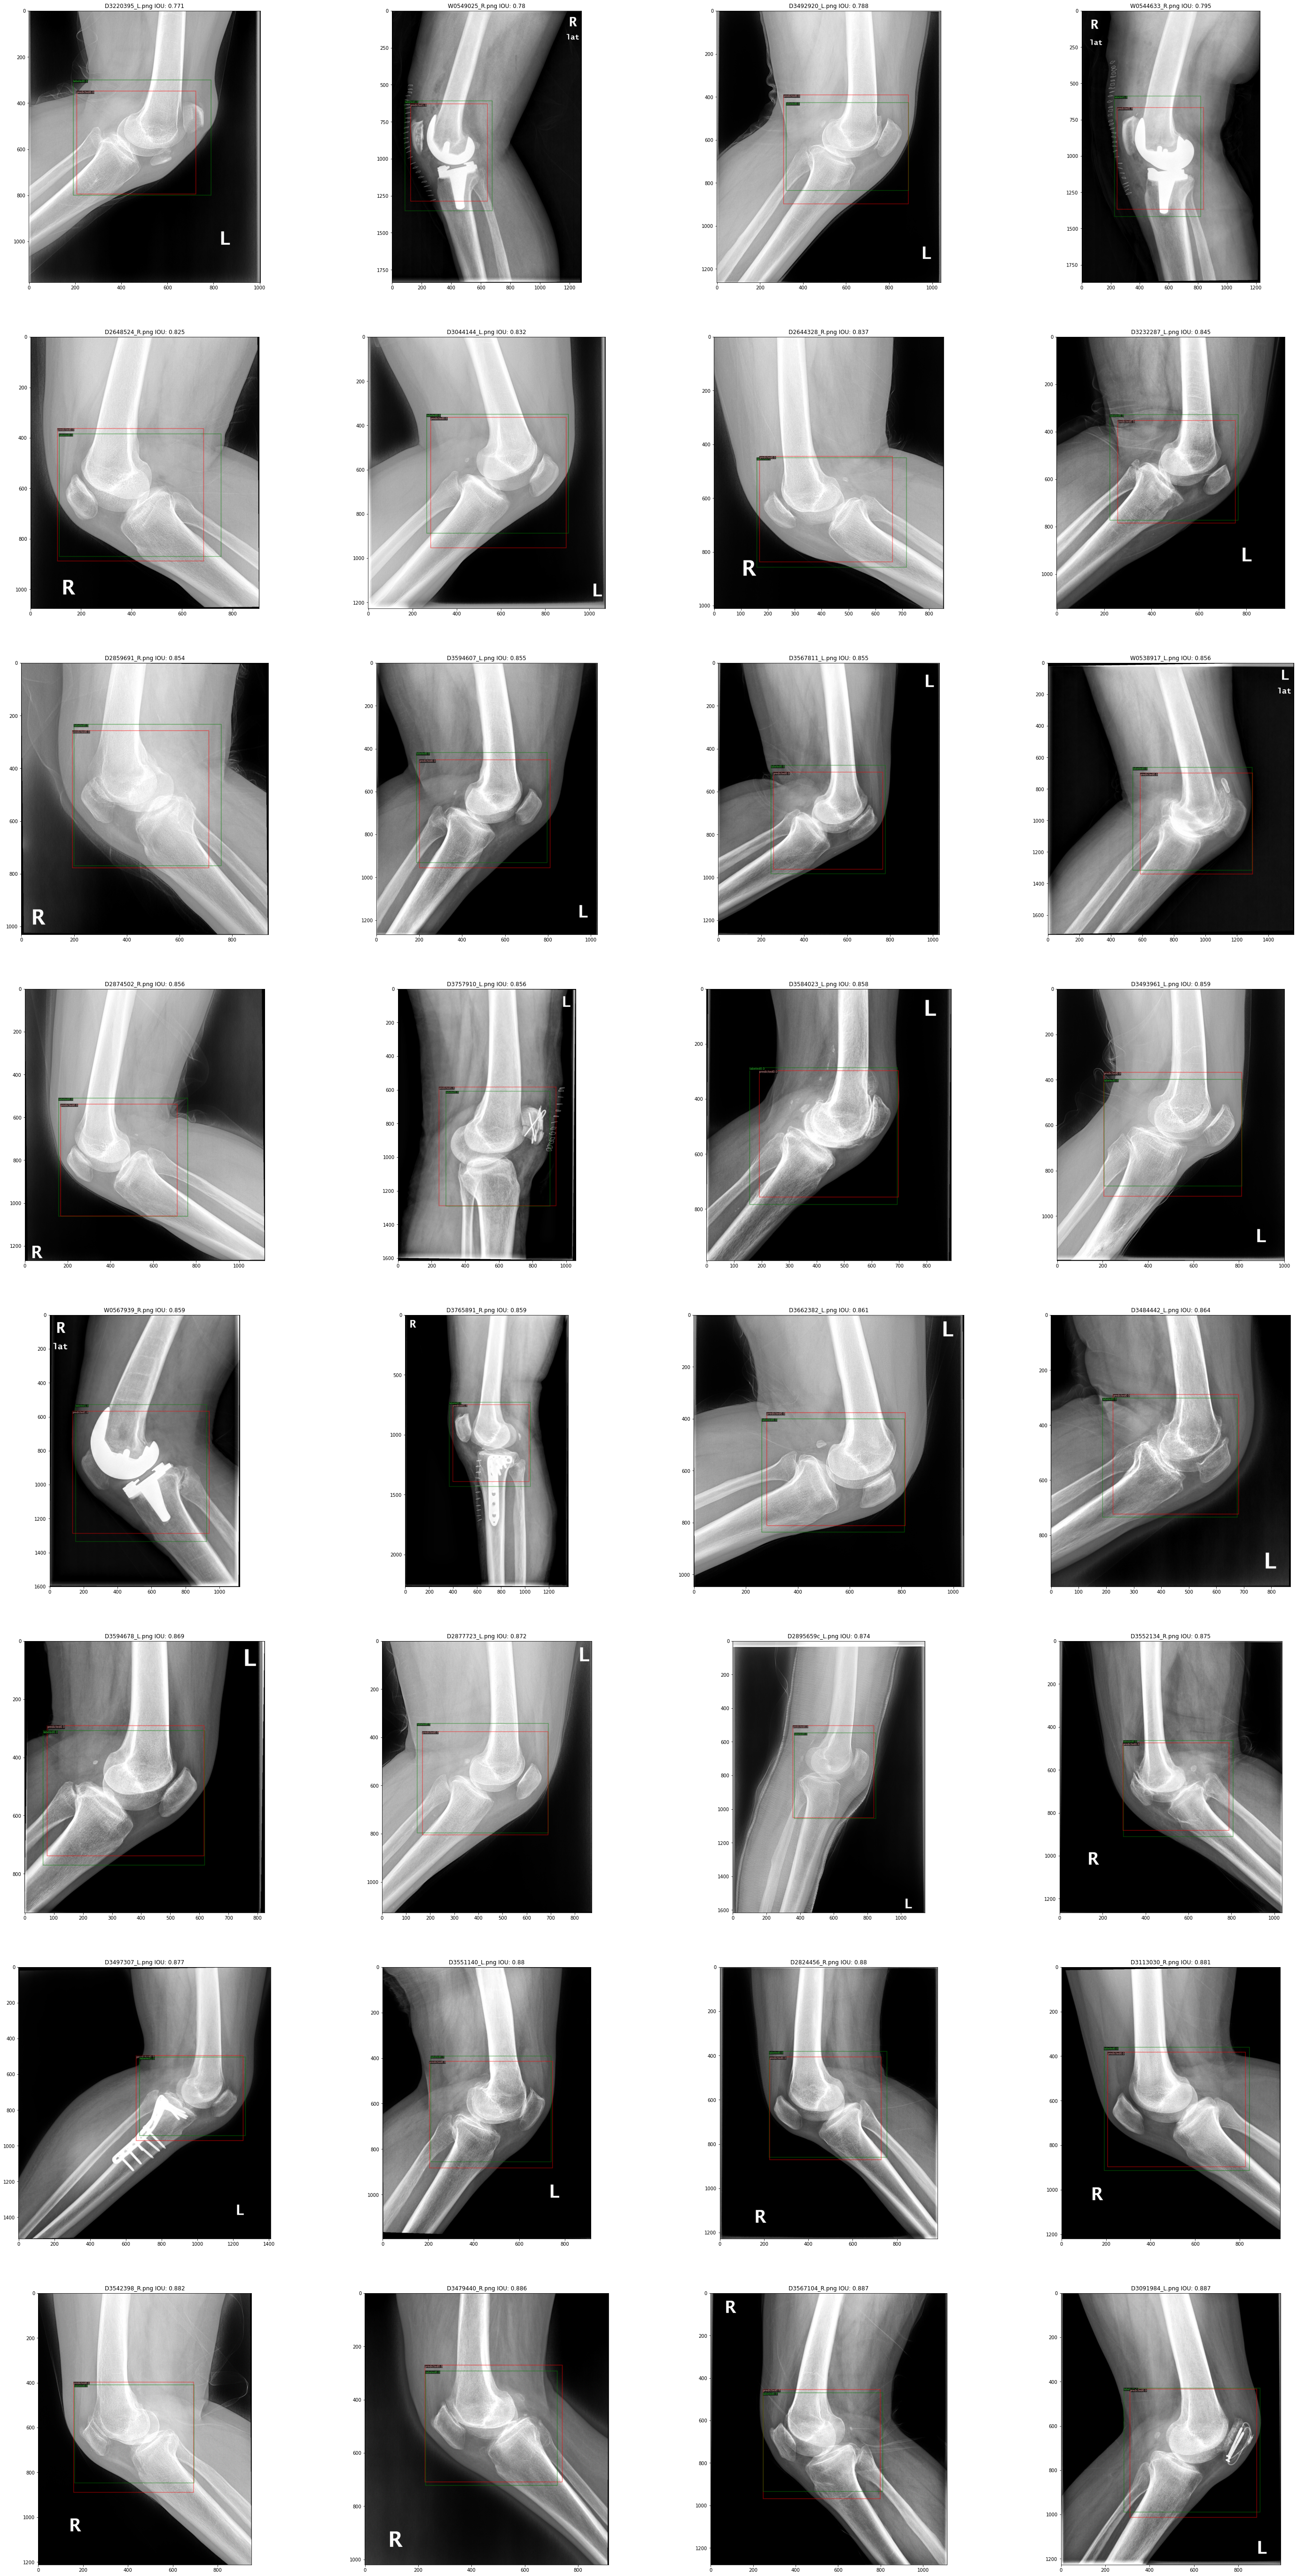

In [23]:
import math
import os
import cv2
import matplotlib.pyplot as plt
from PIL import Image
%matplotlib inline

# only works for 8 bit images for now
fig,axes = plt.subplots(nrows = math.ceil(len(df_AP_bot10)/4), ncols = 4, figsize=(50,100))

for i, image_fn in enumerate(list(df_AP_bot10.index)):
    # src_path = os.path.join('..','KneeQualityAssurance','data','Data', 'ap', 'png_16bit_all')
    src_path = os.path.join('..','KneeQualityAssurance','data','Data', 'ap', 'png_all')
    src_path = os.path.join('..','KneeQualityAssurance','data','Data', 'lat', 'png_all')
    # im = cv2.imread(os.path.join(src_path, image_fn), flags = cv2.IMREAD_ANYCOLOR | cv2.IMREAD_ANYDEPTH)
    im = np.array(Image.open(os.path.join(src_path, image_fn)))
    if len(im.shape) < 3:
        im = np.repeat(im[:, :, np.newaxis], 3, axis=2)
    # outputs = predictor(im)
    v = Visualizer(im,
                   metadata=MetadataCatalog.get("knee_ap_train"), 
                   scale=0.8
    )
    # img_pred_gt = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    gt_bbox = np.array(df_AP_bot10.loc[image_fn][['x1_A', 'y1_A', 'x2_A', 'y2_A']].values)
    pred_bbox = np.array(df_AP_bot10.loc[image_fn][['x1_B', 'y1_B', 'x2_B', 'y2_B']].values)
    img_gt_pred = v.overlay_instances(boxes = np.vstack((gt_bbox, pred_bbox)),
                                      labels = ['labeled'+str(df_AP_bot10.loc[image_fn]['pred_A']), 'predicted'+str(df_AP_bot10.loc[image_fn]['pred_B'])],
                                      assigned_colors=['g','r'])
    # axes[i//4,i%4].imshow(img_gt_pred.get_image(), cmap='bone')
    axes[i//4,i%4].imshow(img_gt_pred.get_image(), cmap='bone')   
    axes[i//4,i%4].set_title(image_fn + ' IOU: {:.3}'.format(df_AP_bot10.loc[image_fn]['IOU']))

In [152]:
import numpy as np

def cal_iou_from_bbox(bboxes1, bboxes2):
    [x11, y11, x12, y12] = bboxes1
    [x21, y21, x22, y22] = bboxes2
    xA = np.maximum(x11, np.transpose(x21))
    yA = np.maximum(y11, np.transpose(y21))
    xB = np.minimum(x12, np.transpose(x22))
    yB = np.minimum(y12, np.transpose(y22)) 
    interArea = np.maximum((xB - xA + 1), 0) * np.maximum((yB - yA + 1), 0)
    boxAArea = (x12 - x11 + 1) * (y12 - y11 + 1)
    boxBArea = (x22 - x21 + 1) * (y22 - y21 + 1)
    iou = interArea / (boxAArea + np.transpose(boxBArea) - interArea)
    return iou    
    

    